<a href="https://colab.research.google.com/github/alyhussein86/C6oUVdljHlRZgnaq/blob/main/P5_ValueInvestor_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
from pandas import DataFrame, to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from datetime import timedelta, datetime
import holidays
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt
from sklearn.model_selection import train_test_split

## Importing Dataframe

In [2]:
# Provide the path to your Excel file
excel_file_path = '/content/2020Q1Q2Q3Q4-2021Q1.xlsx'

# Read the Excel sheet into a pandas DataFrame
df = pd.read_excel(excel_file_path,'Russia - Sberbank Rossii PAO (S')
# df =  pd.read_excel(excel_file_path,'Turkey - Koc Holding AS (KCHOL)')

In [3]:
df = df.iloc[:-1,:2]
print(df)

                    Date   Price
0    2020-01-03 00:00:00     255
1    2020-01-06 00:00:00   253.9
2    2020-01-08 00:00:00  259.15
3    2020-01-09 00:00:00  257.99
4    2020-01-10 00:00:00  258.19
..                   ...     ...
306  2021-03-25 00:00:00  286.66
307  2021-03-26 00:00:00  291.22
308  2021-03-29 00:00:00   293.3
309  2021-03-30 00:00:00  293.25
310  2021-03-31 00:00:00  291.02

[311 rows x 2 columns]


In [4]:
# Filtering DF before the Q1 of second year
specific_date_str = "2020-12-31"
specific_date = pd.to_datetime(specific_date_str)

filtered_df = df[df['Date'] <= specific_date]

In [5]:
filtered_df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

<ipython-input-5-52fe866b4294>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)


In [6]:
# Convert the 'date' column to datetime objects
filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])

<ipython-input-6-a27fe6d10871>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ds'] = pd.to_datetime(filtered_df['ds'])


In [7]:
print(filtered_df)

            ds       y
0   2020-01-03     255
1   2020-01-06   253.9
2   2020-01-08  259.15
3   2020-01-09  257.99
4   2020-01-10  258.19
..         ...     ...
245 2020-12-24  269.32
246 2020-12-25  270.64
247 2020-12-28   274.7
248 2020-12-29     272
249 2020-12-30  271.65

[250 rows x 2 columns]


In [8]:
df_Test = df[df['Date'] > specific_date]

In [9]:
df_Test

,Date,Price
250,2021-01-04 00:00:00,272
251,2021-01-05 00:00:00,275.2
252,2021-01-06 00:00:00,272.93
253,2021-01-08 00:00:00,283.64
254,2021-01-11 00:00:00,289.49
...,...,...
306,2021-03-25 00:00:00,286.66
307,2021-03-26 00:00:00,291.22
308,2021-03-29 00:00:00,293.3
309,2021-03-30 00:00:00,293.25


## Plotting Current Prices of year 2020

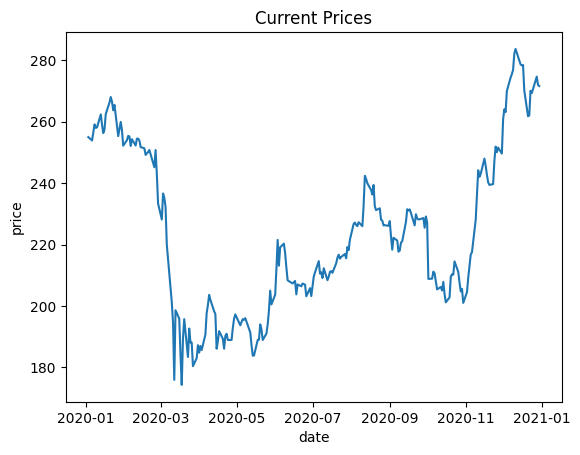

In [10]:
# plot the time series
plt.plot(filtered_df['ds'],filtered_df['y'])
# plt.plot(df_sorted['ds'])
plt.xlabel('date')
plt.ylabel('price')
plt.title('Current Prices')
plt.show()

# Applying Prophet Model

In [11]:
# Create a Prophet model
model_Prophet = Prophet()

# Fit the model
model_Prophet.fit(filtered_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi4ql81qb/owi24lhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi4ql81qb/364hqt7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24200', 'data', 'file=/tmp/tmpi4ql81qb/owi24lhq.json', 'init=/tmp/tmpi4ql81qb/364hqt7x.json', 'output', 'file=/tmp/tmpi4ql81qb/prophet_modelsc279fbf/prophet_model-20231127184042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:40:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:40:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Calculating working days in the period from 1st Jan to 31 Mar


In [12]:
weekend_days = [1,1,1,1,1,0,0]  # Saturday is 5, Sunday is 6

In [13]:
start_date = specific_date.date()
end_date = (specific_date + timedelta(89)).date()

In [14]:
print(start_date)
print(end_date)

2020-12-31
2021-03-30


In [15]:
# Calculate working days by excluding weekends
# business_days = np.busday_count(start_date, end_date, weekmask=weekend_days)

business_days = len(df) - len(filtered_df)

print("Number of business days:", business_days) # -2 (to match the actual data of 61 days)

Number of business days: 61


In [16]:
# Including history to match data indices of current data
future = model_Prophet.make_future_dataframe(periods=business_days, include_history=True)
future.tail(business_days)

,ds
250,2020-12-31
251,2021-01-01
252,2021-01-02
253,2021-01-03
254,2021-01-04
...,...
306,2021-02-25
307,2021-02-26
308,2021-02-27
309,2021-02-28


## Predicting future prices

In [17]:
forecast = model_Prophet.predict(future)
forecast[['ds', 'yhat']].tail(business_days)

,ds,yhat
250,2020-12-31,281.226864
251,2021-01-01,281.289835
252,2021-01-02,269.443118
253,2021-01-03,270.341749
254,2021-01-04,283.687795
...,...,...
306,2021-02-25,331.549875
307,2021-02-26,331.612846
308,2021-02-27,319.766130
309,2021-02-28,320.664760


## Applying Forecasted Prices to the actual dates

In [18]:
df_future = df[df['Date'] > specific_date]
df_future['Date'] = pd.to_datetime(df_future['Date'])

<ipython-input-18-e01012146870>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_future['Date'] = pd.to_datetime(df_future['Date'])


In [19]:
df_future_copy = df_future.copy()

In [20]:
print(df_future_copy)

          Date   Price
250 2021-01-04     272
251 2021-01-05   275.2
252 2021-01-06  272.93
253 2021-01-08  283.64
254 2021-01-11  289.49
..         ...     ...
306 2021-03-25  286.66
307 2021-03-26  291.22
308 2021-03-29   293.3
309 2021-03-30  293.25
310 2021-03-31  291.02

[61 rows x 2 columns]


### Extracting Forecasted Yhat and applying it to the current dates

In [21]:
print(forecast['yhat'].tail(business_days))#.iloc[:-1])

250    281.226864
251    281.289835
252    269.443118
253    270.341749
254    283.687795
          ...    
306    331.549875
307    331.612846
308    319.766130
309    320.664760
310    334.010806
Name: yhat, Length: 61, dtype: float64


In [22]:
df_future_copy['Price'] = forecast['yhat']

In [23]:
df_future_copy.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

In [24]:
print(df_future_copy)

            ds           y
250 2021-01-04  281.226864
251 2021-01-05  281.289835
252 2021-01-06  269.443118
253 2021-01-08  270.341749
254 2021-01-11  283.687795
..         ...         ...
306 2021-03-25  331.549875
307 2021-03-26  331.612846
308 2021-03-29  319.766130
309 2021-03-30  320.664760
310 2021-03-31  334.010806

[61 rows x 2 columns]


## Plotting Forecast

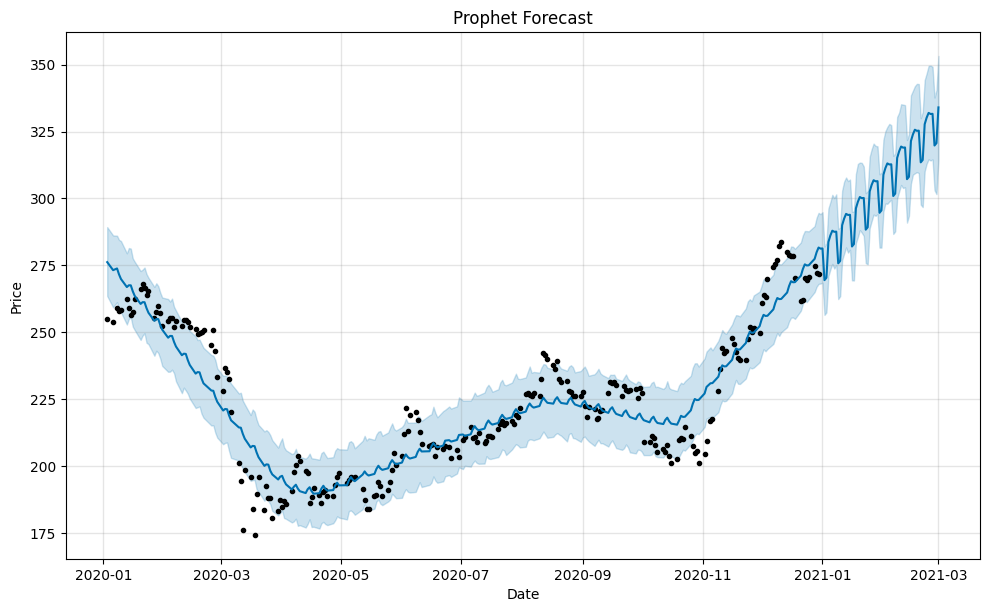

In [25]:
fig = model_Prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

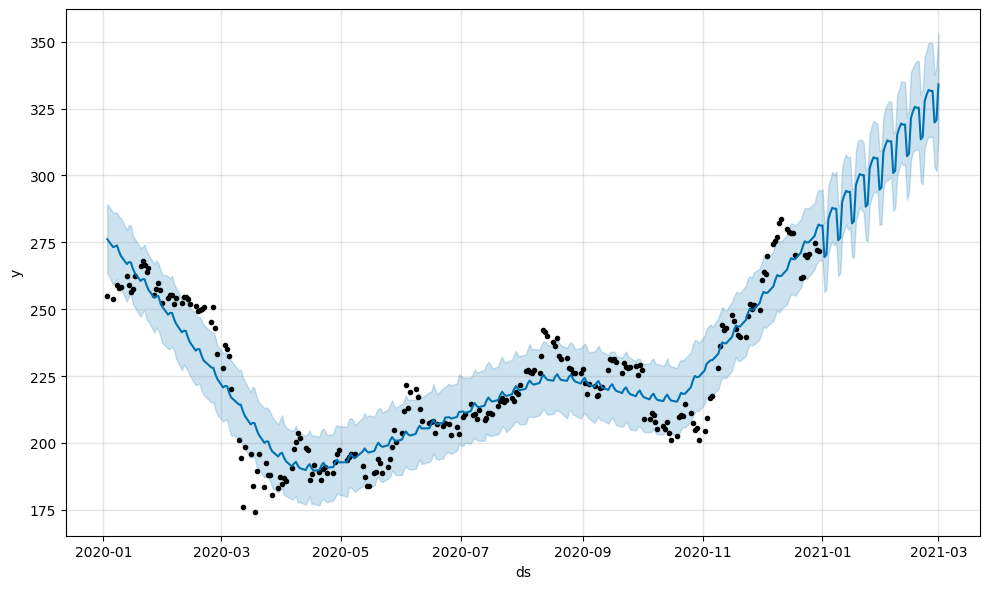

In [26]:
fig1 = model_Prophet.plot(forecast)

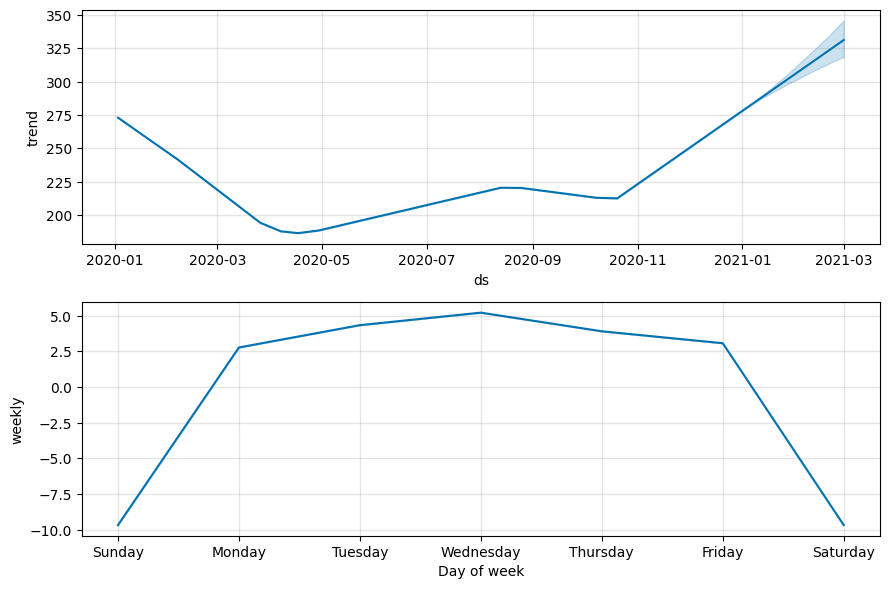

In [27]:
fig2 = model_Prophet.plot_components(forecast)

In [28]:
plot_plotly(model_Prophet, forecast)

## Calculating Mean Absolute Percentage Error

In [29]:
y_true = df['Price'].tail(business_days).values

In [30]:
y_pred = df_future_copy['y'].values

In [31]:
print('predicted= ',y_pred,', Actual= ', y_true)

predicted=  [281.22686369 281.28983502 269.44311832 270.34174863 283.68779477
 286.14989741 287.92502528 287.51724009 287.58021142 275.73349472
 276.63212503 289.97817117 292.44027381 294.21540168 293.80761649
 293.87058782 282.02387112 282.92250143 296.26854757 298.73065021
 300.50577808 300.09799289 300.16096422 288.31424752 289.21287783
 302.55892397 305.02102661 306.79615448 306.38836929 306.45134062
 294.60462392 295.50325423 308.84930037 311.31140301 313.08653088
 312.67874569 312.74171702 300.89500032 301.79363063 315.13967677
 317.60177941 319.37690728 318.96912209 319.03209342 307.18537672
 308.08400703 321.43005317 323.89215581 325.66728368 325.25949849
 325.32246982 313.47575312 314.37438343 327.72042957 330.18253221
 331.95766008 331.54987489 331.61284622 319.76612952 320.66475983
 334.01080597] , Actual=  [272 275.2 272.93 283.64 289.49 289.99 283.78 284.79 276.9 279.79 278.19
 279.8 274.4 268.25 265.3 269.34 265.5 265.96 258.11 263.8 263.15 263.53
 270.11 271.7 275.2 268.

In [32]:
MAPE = mean_absolute_percentage_error(y_true, y_pred)

In [33]:
print('MAPE: %.3f' % MAPE)

MAPE: 0.103


## Plotting Actual vs Forecasted for the 1st Quarter 2021

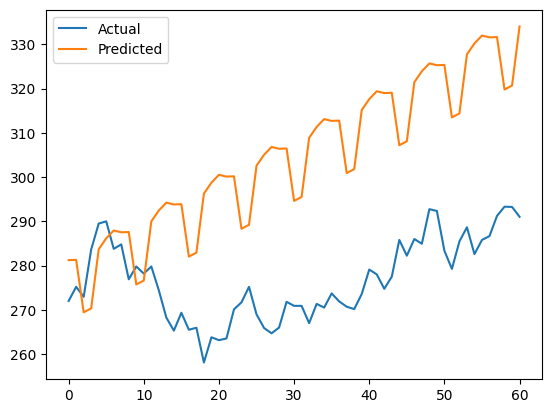

In [34]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

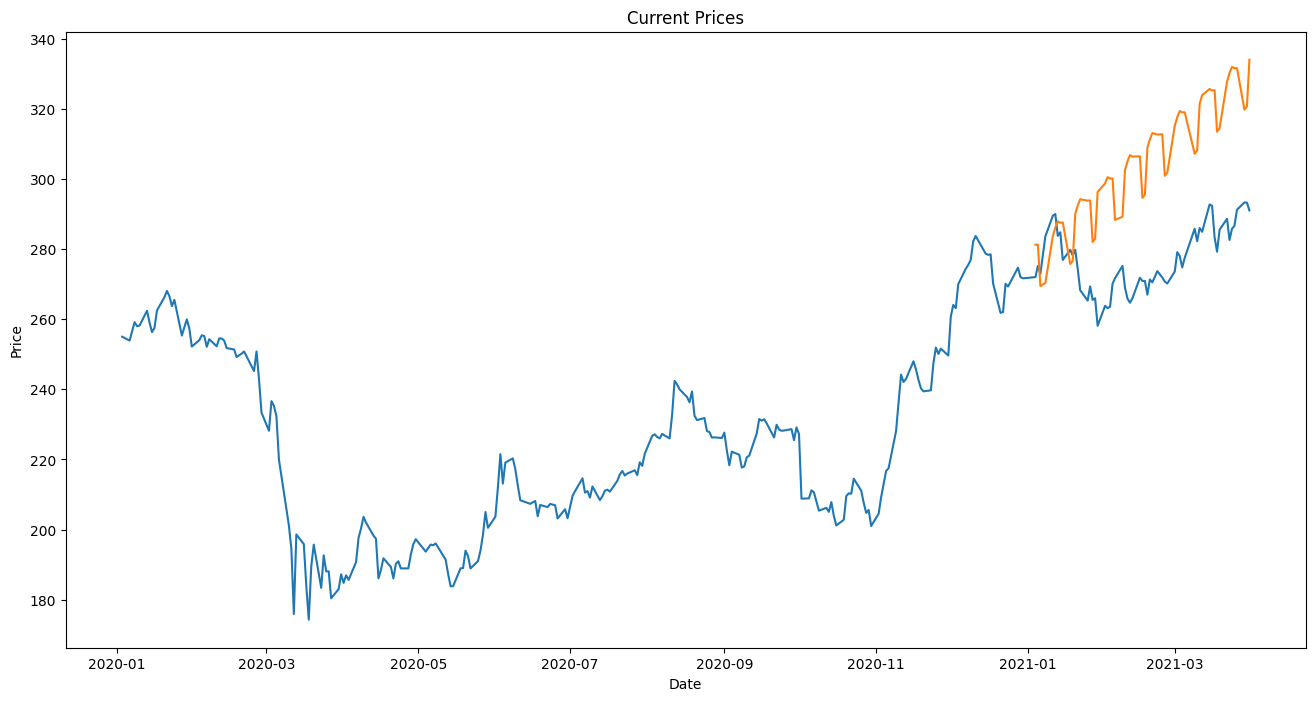

In [35]:
# plot the time series
plt.figure(figsize=(16, 8))
plt.plot(df['Date'],df['Price'], label= 'Actual')
plt.plot(df_future_copy['ds'], df_future_copy['y'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Current Prices')
plt.show()

## Caclulating Bollinger Bands

In [36]:
window = 20  # Number of periods for moving average and standard deviation

In [37]:
df_future_copy = df_future_copy.reset_index(drop=True)

In [38]:
predictions_Bolinger = pd.concat([filtered_df[['ds','y']].tail(window).reset_index(drop=True),df_future_copy]).reset_index(drop=True)

In [39]:
predictions_Bolinger

,ds,y
0,2020-12-03,263.14
1,2020-12-04,270
2,2020-12-07,274.36
3,2020-12-08,275.49
4,2020-12-09,276.89
...,...,...
76,2021-03-25,331.549875
77,2021-03-26,331.612846
78,2021-03-29,319.76613
79,2021-03-30,320.66476


In [40]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(db, window):
    db['SMA'] = db['y'].rolling(window=window).mean()
    db['STD'] = db['y'].rolling(window=window).std()
    db['High'] = db['SMA'] + (2 * db['STD'])
    db['Low'] = db['SMA'] - (2 * db['STD'])
    return db

window_size = 20

# Visualize the stock prices and Bollinger Bands
df_bol = calculate_bollinger_bands(predictions_Bolinger, window_size)

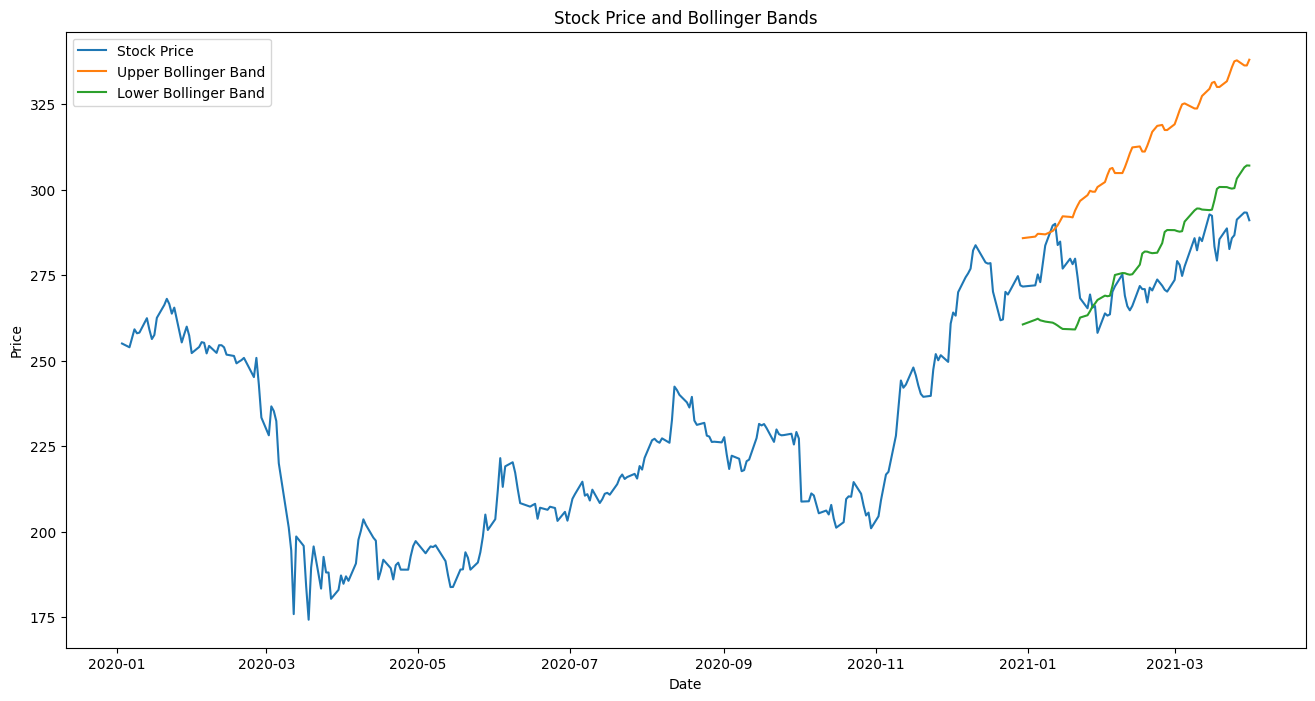

In [41]:
plt.figure(figsize=(16, 8))
plt.plot(df['Date'], df['Price'], label='Stock Price')
plt.plot(df_bol['ds'], df_bol['High'], label='Upper Bollinger Band')
plt.plot(df_bol['ds'], df_bol['Low'], label='Lower Bollinger Band')
plt.title('Stock Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Buy/Hold/Sell Strategy

In [42]:
df_Test = df_Test.reset_index(drop=True)

In [55]:
df_bol = df_bol.tail(len(df_Test)).reset_index(drop=True)

In [47]:
predictions_Bolinger['Signal'] = ''

In [59]:
for i in range(len(df_Test)):
  if df_Test['Price'][i] < df_bol['Low'][i]:
    predictions_Bolinger['Signal'][i] = 'BUY'
  elif df_Test['Price'][i] > df_bol['Low'][i] and df_Test['Price'][i] < df_bol['High'][i]:
    predictions_Bolinger['Signal'][i] = 'HOLD'
  else: predictions_Bolinger['Signal'][i] = 'Sell'

<ipython-input-59-e11fab8ca5e2>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-59-e11fab8ca5e2>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-59-e11fab8ca5e2>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



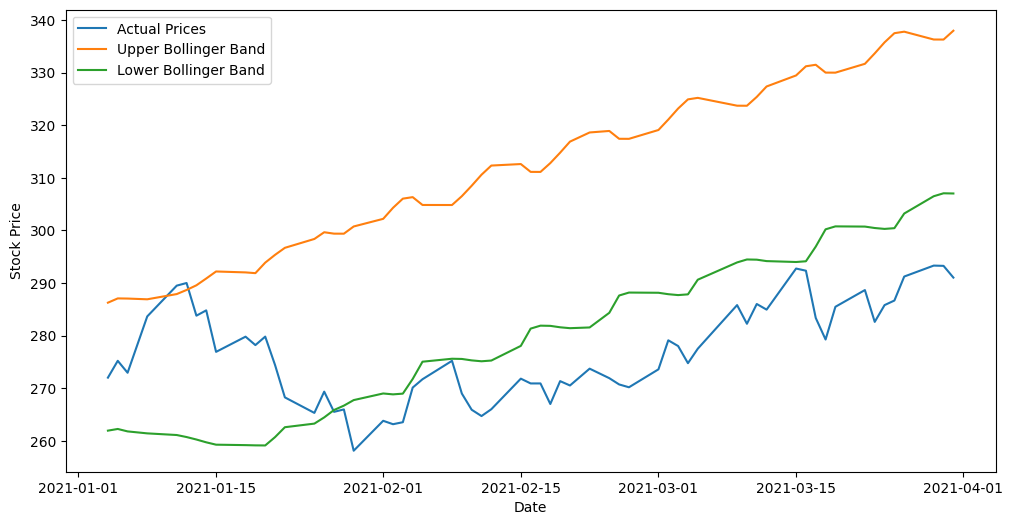

BUY     45
        20
HOLD    14
Sell     2
Name: Signal, dtype: int64


In [91]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df_Test['Date'], df_Test['Price'], label='Actual Prices')
plt.plot(df_bol['ds'], df_bol['High'], label='Upper Bollinger Band')
plt.plot(df_bol['ds'], df_bol['Low'], label='Lower Bollinger Band')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Display buy/sell signals
print(predictions_Bolinger['Signal'].value_counts())

# Applying LSTM Model

### Importing DataFrame

In [61]:
# Filtering DF before the Q1 of second year
df_pd = df

print(df_pd)

                    Date   Price
0    2020-01-03 00:00:00     255
1    2020-01-06 00:00:00   253.9
2    2020-01-08 00:00:00  259.15
3    2020-01-09 00:00:00  257.99
4    2020-01-10 00:00:00  258.19
..                   ...     ...
306  2021-03-25 00:00:00  286.66
307  2021-03-26 00:00:00  291.22
308  2021-03-29 00:00:00   293.3
309  2021-03-30 00:00:00  293.25
310  2021-03-31 00:00:00  291.02

[311 rows x 2 columns]


In [62]:
df_pd['Date'] = pd.to_datetime(df_pd['Date'])

In [63]:
df_pd['Price'] = df_pd['Price'].astype(float)

In [64]:
df_pd.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

## LSTM Data preparation

In [65]:
train = df_pd[df_pd['Date'] < specific_date]

In [66]:
print(train.shape)

(250, 2)


In [67]:
test = df_pd[df_pd['Date'] >= specific_date]

In [68]:
print(test.shape)

(61, 2)


In [69]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_pd['Price'].values.reshape(-1,1))
# df_scaled_test = scaler.fit_transform(test['Price'].values.reshape(-1,1))
# df_scaled = pd.DataFrame(df_scaled, columns=['Price'])
# df_scaled['Date'] = df['Date']

In [70]:
# Split the data into training and testing sets
train_size = int(len(train))
train_data, test_data = df_scaled[0:train_size], df_scaled[train_size:]

# Function to create sequences of data for training
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30  # Number of previous time steps to use for prediction
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

In [71]:
# Reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [72]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((220, 30, 1), (220,), (31, 30, 1), (31,))

## Training LSTM Model

In [73]:
# Create and train the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
14/14 [==============================] - 2s 14ms/step - loss: 0.1145
Epoch 2/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0218
Epoch 3/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0139
Epoch 4/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0114
Epoch 5/100
14/14 [==============================] - 0s 15ms/step - loss: 0.0099
Epoch 6/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0084
Epoch 7/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 8/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0065
Epoch 9/100
14/14 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 10/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0062
Epoch 11/100
14/14 [==============================] - 0s 13ms/step - loss: 0.0060
Epoch 12/100
14/14 [==============================] - 0s 14ms/step - loss: 0.0059
Epoch 13/100
14/14 [=====

In [74]:
# Make predictions
predict_X = model.predict(X_train[-1])
# test_predict = model.predict(X_test[-1])

1/1 [==============================] - 0s 479ms/step


In [75]:
# Inverse transform predictions to original scale
predict_X = scaler.inverse_transform(predict_X)
# test_predict = scaler.inverse_transform([y_test])

In [76]:
print(predict_X)

[[196.77606]
 [196.08218]
 [195.84111]
 [195.92049]
 [198.0974 ]
 [199.41685]
 [198.89427]
 [199.32434]
 [198.75882]
 [202.00734]
 [202.96178]
 [202.69115]
 [204.71759]
 [206.01549]
 [206.3531 ]
 [206.7721 ]
 [208.36812]
 [208.82997]
 [207.6905 ]
 [207.3149 ]
 [207.20984]
 [207.25487]
 [204.76508]
 [202.29468]
 [202.36803]
 [204.74727]
 [204.51585]
 [204.90762]
 [206.11702]
 [205.31201]]


In [77]:
# Create a copy of X_test to store the updated values
X_test_updated = X_train[-1].reshape(1, 30)
num_days_to_predict = len(test)
print(X_test_updated.shape)

(1, 30)


In [78]:
# Make predictions for the next 90 days and update X_test
predictions_list = []
for i in range(num_days_to_predict):
    # Make predictions for the current day
    predictions_new = model.predict(X_test_updated)
    #predictions = scaler.inverse_transform(predictions)

    # Append the predictions to X_test_updated for the next day
    X_test_updated = np.append(X_test_updated, predictions_new, axis=1)

    # Delete the first element from the array
    X_test_updated = X_test_updated[:, 1:]

    # Append the predictions to the list for plotting later
    predictions_list.append(predictions_new[0, 0])  # Assuming the prediction is a single value (e.g., the first column)

# reshape the predictions_list
predictions_list = np.array(predictions_list).reshape(-1, 1)
# apply the scaler.inverse_transform functio nto all the values in the predictions_list
predictions_list = scaler.inverse_transform(predictions_list)
# make a data frame from the predictions_list and add a column based on df['Date'][252:]
df_predictions = pd.DataFrame(predictions_list, columns=['Price'])

1/1 [==============================] - 0s 23ms/step


In [79]:
# Filter the dates to keep only those from the year 2021
dates_2021 = test['Date']

# Reset the index to start from 0
dates_2021.reset_index(drop=True, inplace=True)

# Assign the filtered dates to the 'Date' column in 'df_predictions'
df_predictions['Date'] = dates_2021

df_predictions = df_predictions[['Date','Price']]

## Plotting Actual vs Forecasted for the 1st Quarter 2021

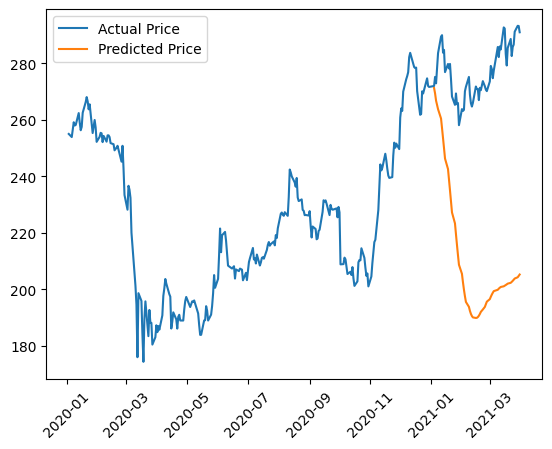

In [80]:
# plot the predictions_list
plt.plot(df_pd['Date'], df_pd['Price'], label ='Actual Price')
plt.tick_params(axis='x', rotation=45)
plt.plot(df_predictions['Date'],df_predictions['Price'], label = 'Predicted Price')
plt.legend()
plt.show()

In [81]:
df_predictions_Bolinger = pd.concat([train[['Date','Price']].tail(window),df_predictions]).reset_index(drop=True)

In [82]:
df_predictions_Bolinger

,Date,Price
0,2020-12-03,263.140000
1,2020-12-04,270.000000
2,2020-12-07,274.360000
3,2020-12-08,275.490000
4,2020-12-09,276.890000
...,...,...
76,2021-03-25,203.349579
77,2021-03-26,203.776505
78,2021-03-29,204.230957
79,2021-03-30,204.708603


## Calculating Bolinger for LSTM

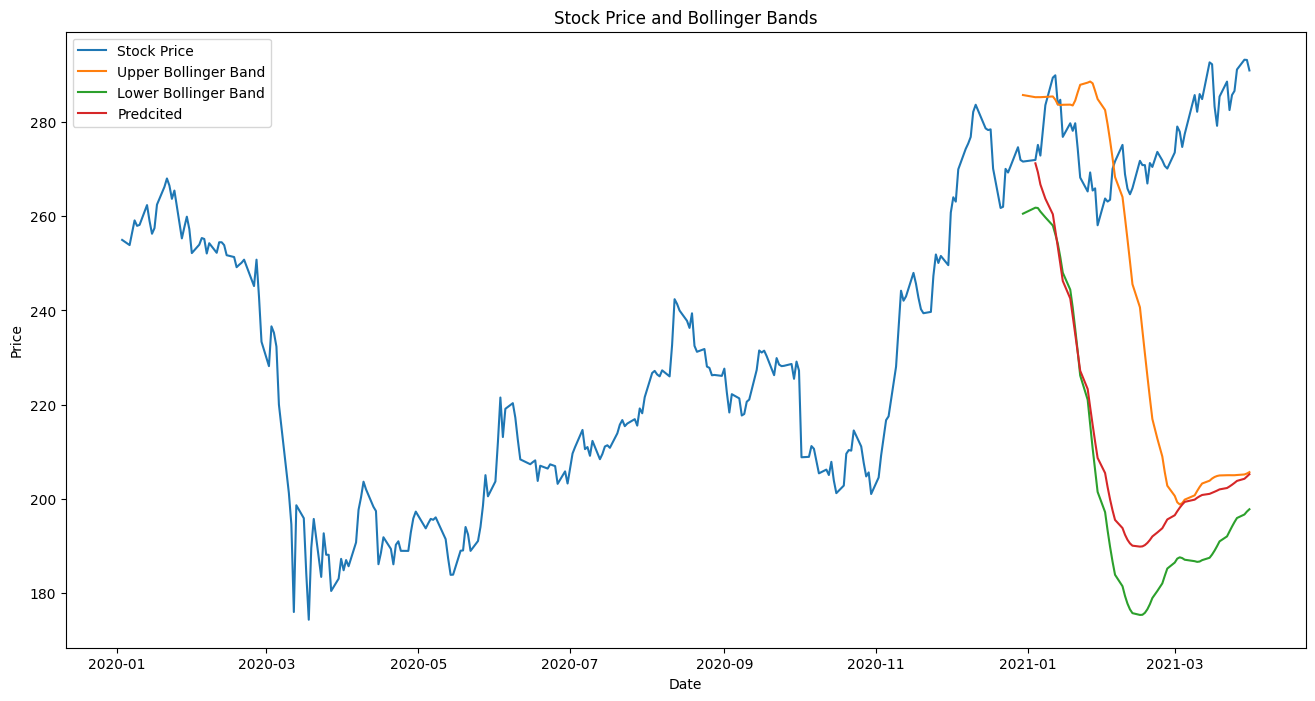

In [83]:
# Calculate Bollinger Bands
def calculate_bollinger_bands(db, window):
    db['SMA'] = db['Price'].rolling(window=window).mean()
    db['STD'] = db['Price'].rolling(window=window).std()
    db['High'] = db['SMA'] + (2 * db['STD'])
    db['Low'] = db['SMA'] - (2 * db['STD'])
    return db

window_size = 20

# Visualize the stock prices and Bollinger Bands
df_b = calculate_bollinger_bands(df_predictions_Bolinger, window_size)

plt.figure(figsize=(16, 8))
plt.plot(df_pd['Date'], df_pd['Price'], label='Stock Price')
plt.plot(df_b['Date'], df_b['High'], label='Upper Bollinger Band')
plt.plot(df_b['Date'], df_b['Low'], label='Lower Bollinger Band')
plt.plot(df_predictions['Date'], df_predictions['Price'],label='Predcited')
plt.title('Stock Price and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Buy/Hold/Sell Strategy

In [84]:
test = test.reset_index(drop=True)

In [85]:
df_b = df_b.tail(len(test)).reset_index(drop=True)

In [86]:
df_b['Signal'] = ''

In [87]:
for i in range(len(test)):
  if test['Price'][i] < df_b['Low'][i]:
    df_b['Signal'][i] = 'BUY'
  elif test['Price'][i] > df_b['Low'][i] and test['Price'][i] < df_b['High'][i]:
    df_b['Signal'][i] = 'HOLD'
  else: df_b['Signal'][i] = 'Sell'

<ipython-input-87-eeb5633ad9d4>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-87-eeb5633ad9d4>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



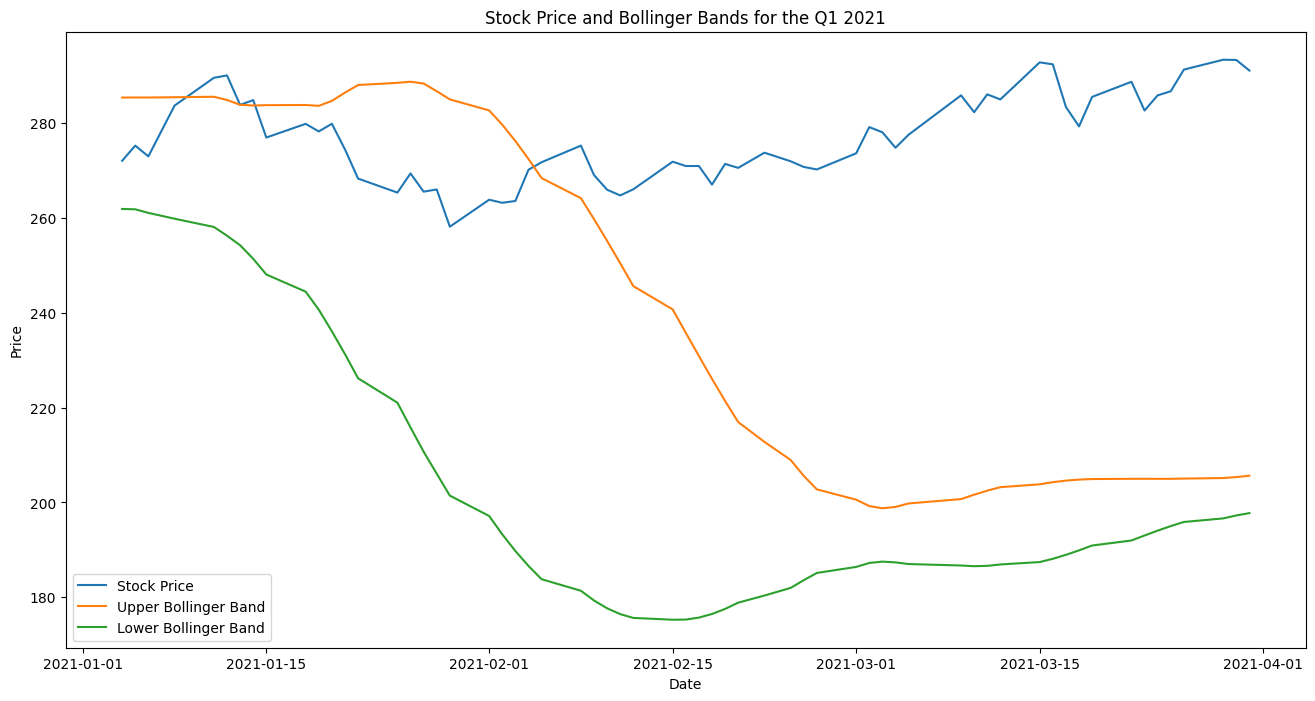

Sell    41
HOLD    20
Name: Signal, dtype: int64


In [88]:
# Visualize the results
plt.figure(figsize=(16, 8))
plt.plot(test['Date'], test['Price'], label='Stock Price')
plt.plot(df_b['Date'].tail(len(test)), df_b['High'].tail(len(test)), label='Upper Bollinger Band')
plt.plot(df_b['Date'].tail(len(test)), df_b['Low'].tail(len(test)), label='Lower Bollinger Band')
# plt.plot(df_predictions['Date'], df_predictions['Price'],label='Predcited')
plt.title('Stock Price and Bollinger Bands for the Q1 2021')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Display buy/sell signals
print(df_b['Signal'].value_counts())